# Phase_vocoder

Требуется реализовать алгоритм phase_vocoder по статье: http://www.guitarpitchshifter.com/algorithm.html\
Алгоритм предназначен для растягивания по времени цифрового аудио-сигнала без изменения питча.\
Язык реализации: Python или C++.\
При помощи реализованного алгоритма требуется растянуть в 2 раза и сжать в 2 раза (по длительности) прилагаемую аудиозапись.\
При реализации алгоритма допускается использовать библиотечные функции для чтения wav-файлов, прямого и обратного преобразования фурье.<p>

Проверка будет проходить следующим образом:\
`cd solution && ./run.sh <input.wav> <output.wav> <time_stretch_ratio>`\
где:\
<input.wav> -- путь для исходного wav файла\
<output.wav> -- путь до файла, который является результатом работы программы\
<time_stretch_ratio> -- параметр `r` алгоритма. (0 < r < 1 - сжимаем, 1 <= r - растягиваем)


In [116]:
from scipy.io import wavfile
from os.path import dirname, join as pjoin
import scipy.io
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

In [117]:
def plot_wav_freq(samplerate: int, data: np.ndarray) -> None:
    """
    ### Отрисовывает график частоты и громкости аудиодорожки
    """
    length = data.shape[0] / samplerate
    track_count = 0
    time = np.linspace(0., length, data.shape[0])

    fig = plt.figure()
    fig.set_size_inches(20, 8)
    
    try:        
        ax1 = plt.subplot(2, 1, 1)
        plt.plot(time, data[:, 0], label="Left channel")
        
        ax2 = plt.subplot(2, 1, 2)
        plt.plot(time, data[:, 1], label="Right channel")
        
        track_count = 2
        
    except IndexError:
        plt.plot(time, data[:], label="Main channel")
        
        track_count = 1
    
    print(f'Длина аудио - {length:.3f}s\nЧисло дорожек - {track_count}')
    print(f'Частота дискретизации - {samplerate} Гц')
        
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    
    plt.show()

In [118]:
WAV_NAME = 'test_mono.wav'
SHIFT = 1.25

Длина аудио - 16.797s
Число дорожек - 1
Частота дискретизации - 16000 Гц


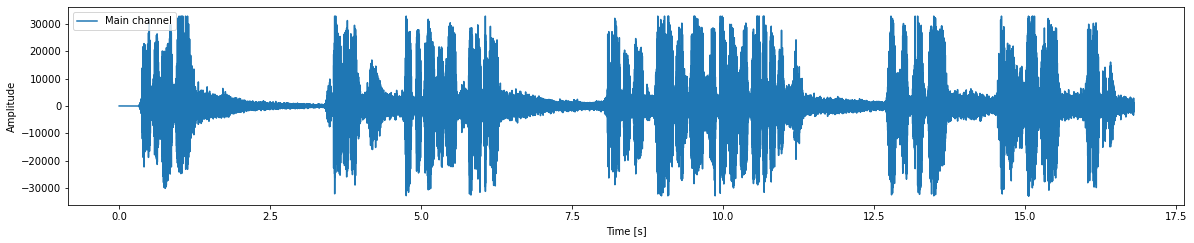

In [119]:
samplerate, data = wavfile.read(f'./input/{WAV_NAME}')
plot_wav_freq(samplerate=samplerate, data=data)

In [390]:
data.shape

(268748,)

In [275]:
FRAME_SIZE = int(data.shape[0] // 1000)
OVERLAP = 0.75
HOP_A = int(FRAME_SIZE - (FRAME_SIZE * OVERLAP))

In [339]:
from scipy.fft import fft
from scipy.signal.windows import hann
from typing import List, Optional

def analysis(data: np.ndarray, samplerate: int, frame_size: int = FRAME_SIZE, overlap: float = OVERLAP, hop_size: int = HOP_A) -> List[np.ndarray]:
    """
    Compute the discrete spectrum of a signal.

    Args:
        data: numpy array of shape (n,)
            The input signal to compute the spectrum for.
        frame_size: int, optional (default=n//1000)
            The size of each frame, in samples.
        overlap: float, optional (default=0.75)
            The overlap (hop size) of frames.

    Returns:
        spectrum: list of numpy arrays shaped (frame_size,)
            The spectral amplitude at each frequency bin for each frame.
    """
    hop_size = int(frame_size - (frame_size * overlap))
    num_frames = 1 + (data.shape[0] - frame_size) // hop_size
    hann_window = hann(frame_size)
    spectrum = np.zeros((frame_size // 2 + 1, num_frames))
    
    for i in range(num_frames):
        frame = data[i*hop_size:i*hop_size+frame_size] * hann_window
        spectrum[:, i] = (np.abs(fft(frame)[:frame_size // 2 + 1]))
        
    frequencies = np.fft.fftfreq(frame_size, 1/samplerate)[:frame_size//2 + 1]
        
    return spectrum, frequencies

spectrum, frequencies = analysis(data, samplerate)

In [397]:
spectrum.shape

(135, 4008)

In [306]:
def phase_shift(data: np.ndarray, samplerate: int, frequencies: np.ndarray, frame_size: int = FRAME_SIZE, hop_size: int = HOP_A) -> np.ndarray:
    """
    Compute phase shift.
    """
    num_frames = data.shape[1]
    w_true = w_freq = w_wrapped = np.zeros((frame_size // 2 + 1, num_frames))
    
    for i in range(1, num_frames):
        w_freq[:, i-1] = (data[:, i] - data[:, i-1]) / (hop_size / samplerate) - frequencies
        w_wrapped[:, i-1] = (w_freq[:, i-1] + np.pi) % (2 * np.pi) - np.pi
        w_true[:, i-1] = w_wrapped[:, i-1] + frequencies
        
    phase = np.zeros((frame_size // 2 + 1, num_frames))
    hop_s = int(data.shape[0] - (data.shape[0] * OVERLAP))
    for i in range(1, num_frames):
        phase[:, i] = data[:, i-1] + (hop_s / samplerate) * w_true[:, i]

    return phase

phase = phase_shift(spectrum, samplerate, frequencies)

In [388]:
def synthesation(data: np.ndarray, frequencies: np.ndarray, frame_size: int = FRAME_SIZE, hop_size: int = HOP_A):
    hop_s = int(data.shape[0] - (data.shape[0] * OVERLAP))
    num_frames = data.shape[1]
    hann_window = hann(data.shape[0])
    Q_i = np.zeros((data.shape[0], num_frames))
    
    print(f'Data shape: {data.shape}\nHops: {hop_s}\nNum_frames: {num_frames}\nHann shape: {hann_window.shape}')
    
    for i in range(num_frames):
        Q_i[:, i] = np.mean(fft(np.abs(data[:, i]))) * hann_window
        
    res = np.zeros((data.shape[0], num_frames))
        
    return res
        
    # frame = data[i*hop_size:i*hop_size+frame_size] * hann_window

res = synthesation(phase, frequencies)

Data shape: (135, 4008)
Hops: 33
Num_frames: 4008
Hann shape: (135,)


C:\Users\George\AppData\Local\Temp\ipykernel_8792\3042806807.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  Q_i[:, i] = np.mean(fft(np.abs(data[:, i]))) * hann_window


In [389]:
res.shape

(135, 4008)

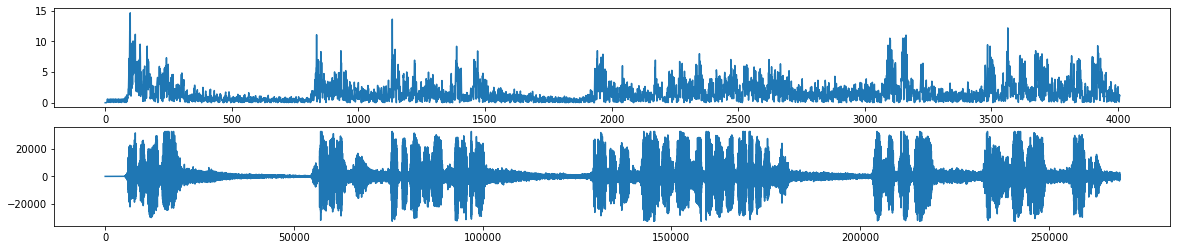

In [382]:
fig = plt.figure()
fig.set_size_inches(20, 4)

ax1 = plt.subplot(2,1,1)
plt.plot(res[1])
ax2 = plt.subplot(2,1,2)
plt.plot(data)
plt.show()